<a href="https://colab.research.google.com/github/KeshavaOfficial/CPP/blob/main/DS544FinalEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling
!pip install plotly


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=456bb1ad038b9f608174c4b3a45829bb6397db2fb8b48fe07f35cc8dd71d7801
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.dates as mdates



In [ ]:
# Load dataset
df = pd.read_csv('PJMW_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')



In [ ]:
# Profile report
profile = ProfileReport(df, explorative=True)
profile.to_notebook_iframe()



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Remove duplicates and set index
df = df.drop_duplicates(subset='Datetime', keep='first')
df.set_index('Datetime', inplace=True)
df = df.asfreq('H')  # Ensure hourly frequency



<ipython-input-4-b6d4741b48ff>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')  # Ensure hourly frequency


In [ ]:
# Interpolation and missing values
print(f"Nulls after indexing: {df['PJMW_MW'].isnull().sum()}")
df['MW_clean'] = df['PJMW_MW'].interpolate(method='time')



Nulls after indexing: 30


In [ ]:
# Outlier detection and handling
z_scores = np.abs(stats.zscore(df['MW_clean'].dropna()))
df['outlier'] = False
df.loc[df['MW_clean'].dropna().index[z_scores > 3], 'outlier'] = True
df.loc[df['outlier'], 'MW_clean'] = np.nan
df['MW_clean'] = df['MW_clean'].interpolate(method='time')



In [ ]:
# Check for duplicate index entries
print(f"Duplicate after cleaning: {df.index.duplicated().sum()}")



Duplicate after cleaning: 0


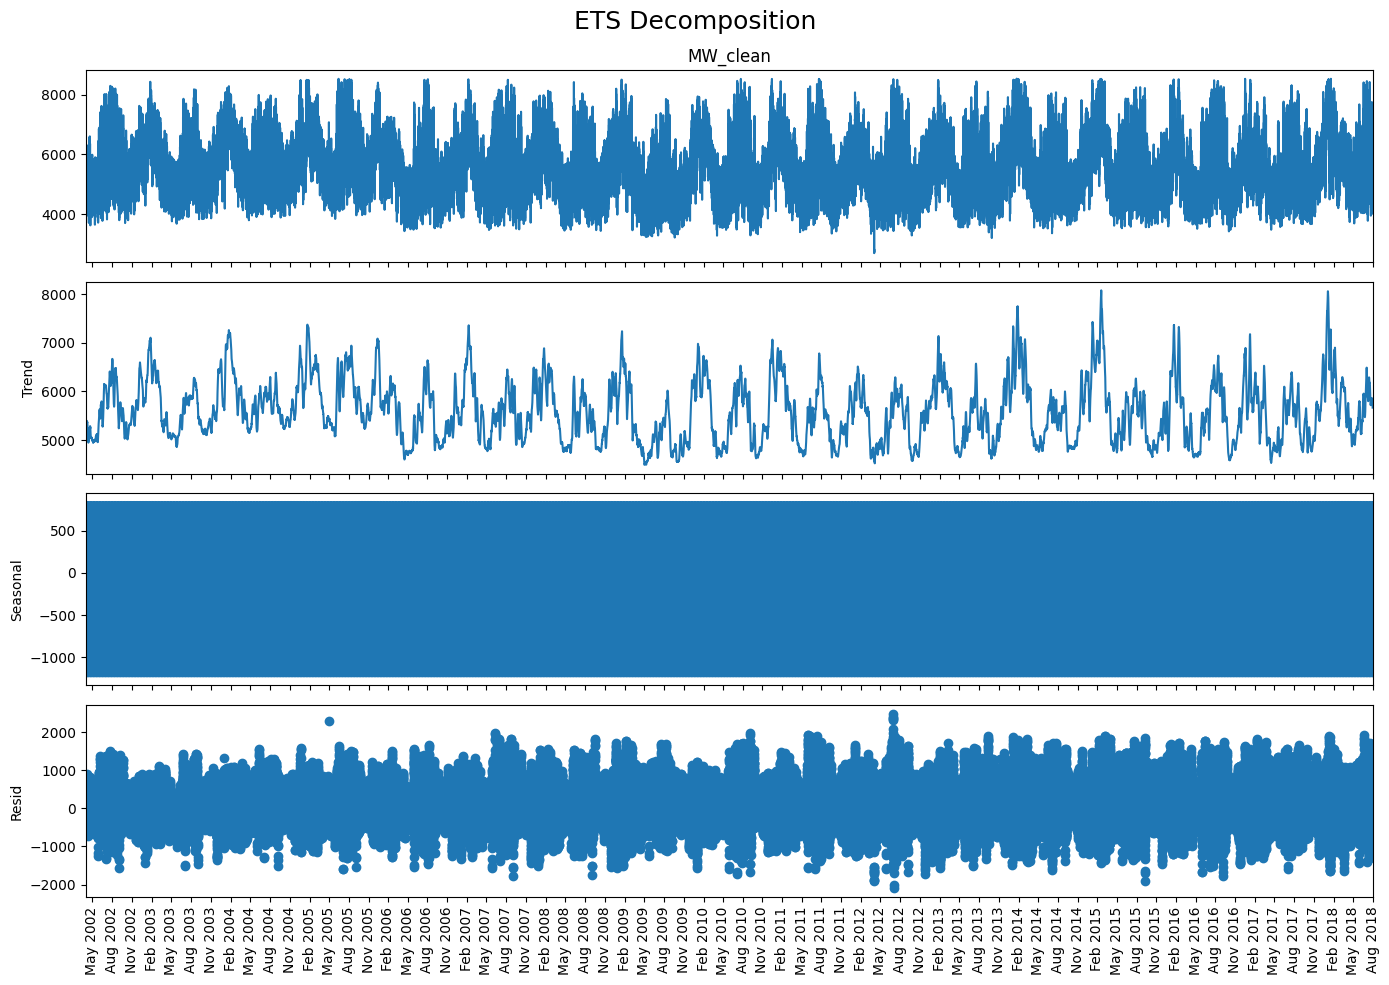

In [ ]:
# ETS Decomposition
result = seasonal_decompose(df['MW_clean'], model='additive', period=168)
fig = result.plot()
fig.set_size_inches(14, 10)
fig.suptitle("ETS Decomposition", fontsize=18)
for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



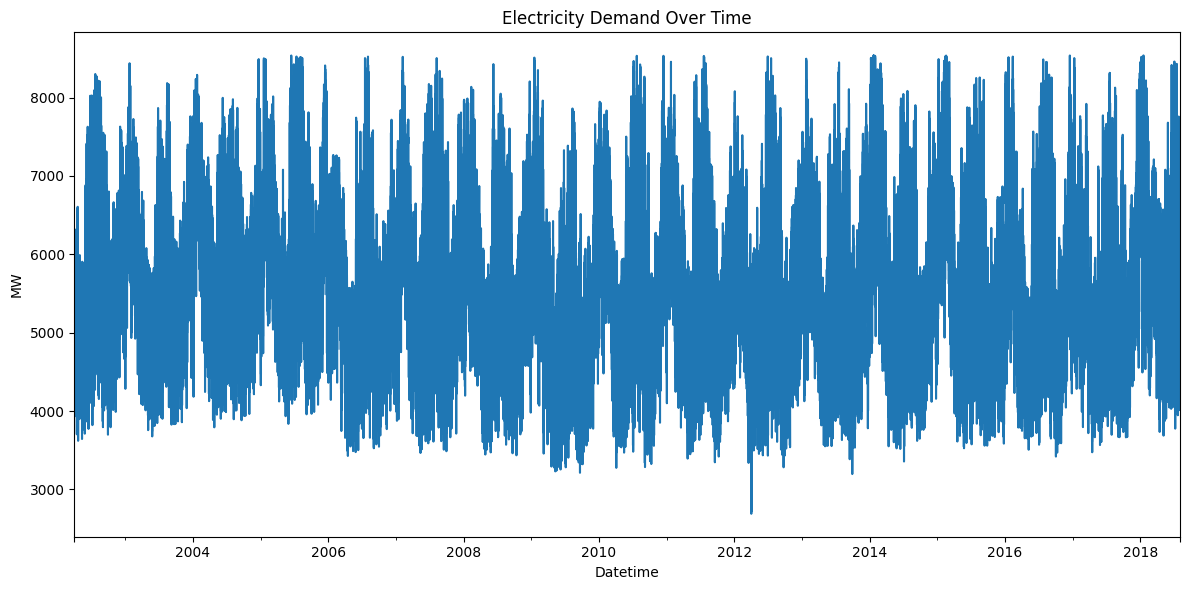

In [ ]:
# Line plot
plt.figure(figsize=(12, 6))
df['MW_clean'].plot()
plt.title('Electricity Demand Over Time')
plt.ylabel('MW')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()



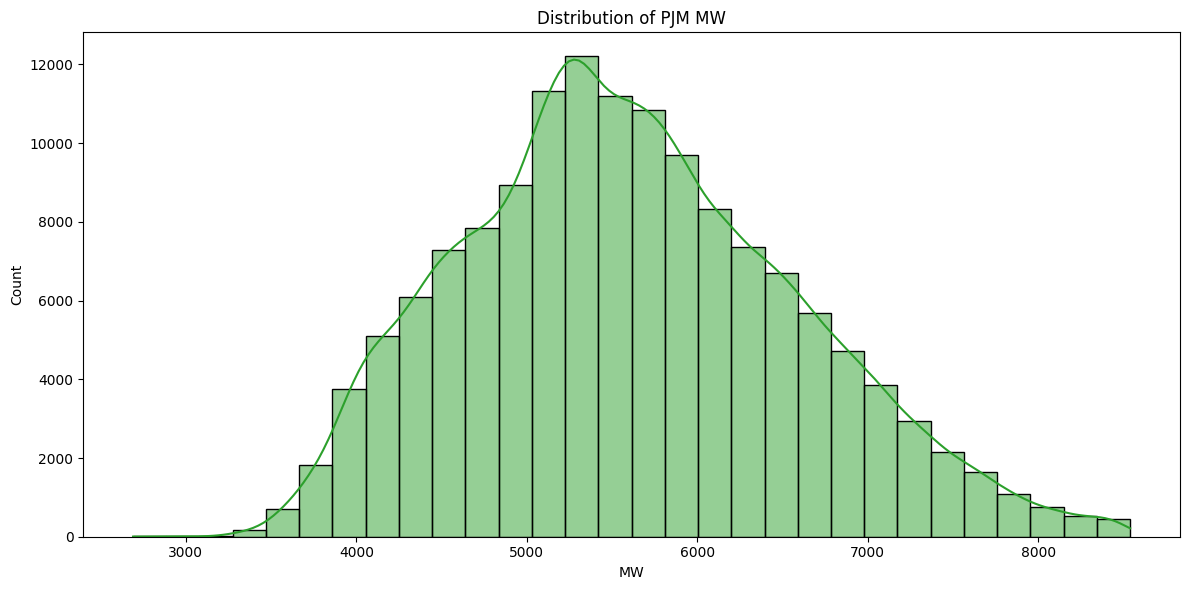

In [ ]:
# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['MW_clean'], kde=True, bins=30, color='tab:green')
plt.title('Distribution of PJM MW')
plt.xlabel('MW')
plt.tight_layout()
plt.show()



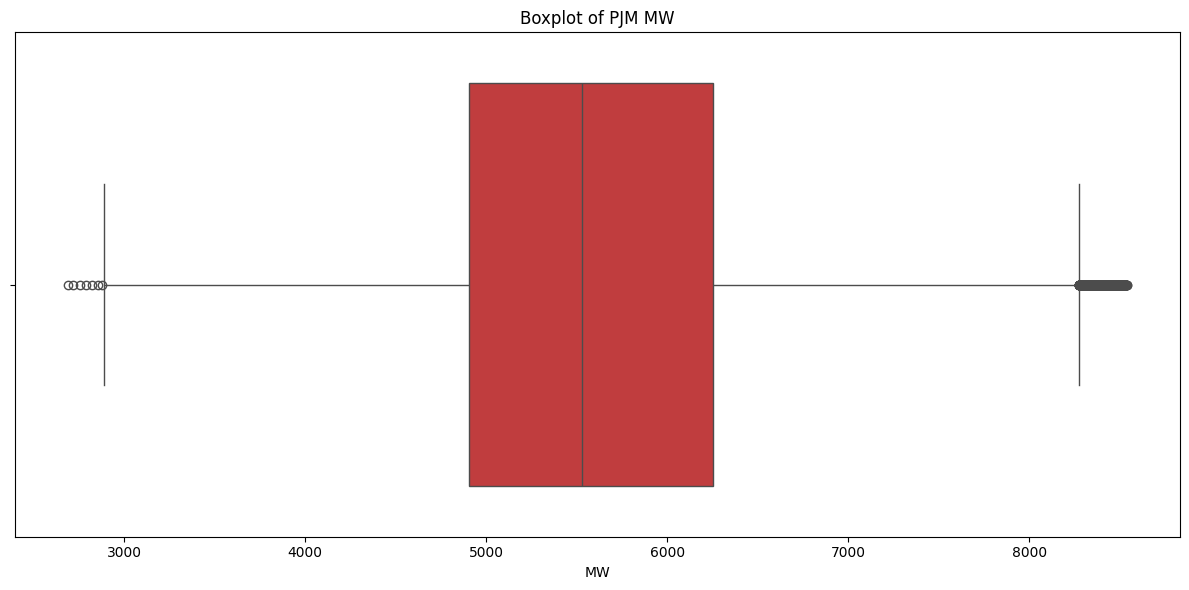

In [ ]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['MW_clean'], color='tab:red')
plt.title('Boxplot of PJM MW')
plt.xlabel('MW')
plt.tight_layout()
plt.show()



<ipython-input-12-f0e506051954>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=weekly_avg.values, palette='viridis')


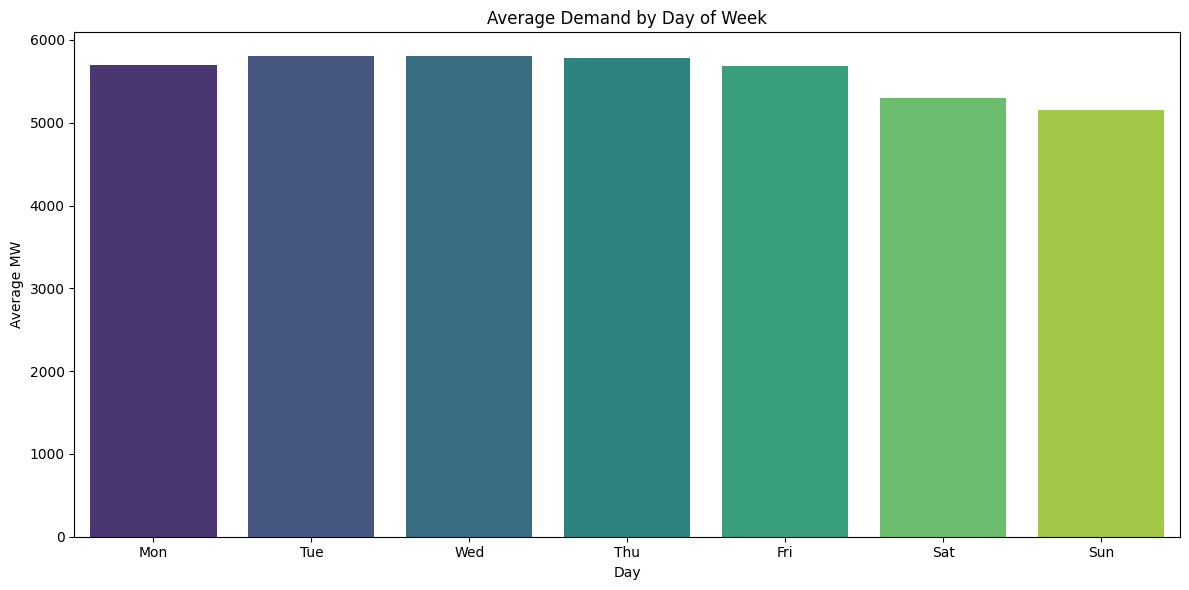

In [ ]:
# Weekly Seasonality
plt.figure(figsize=(12, 6))
weekly_avg = df.groupby(df.index.dayofweek)['MW_clean'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=days, y=weekly_avg.values, palette='viridis')
plt.title('Average Demand by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average MW')
plt.tight_layout()
plt.show()



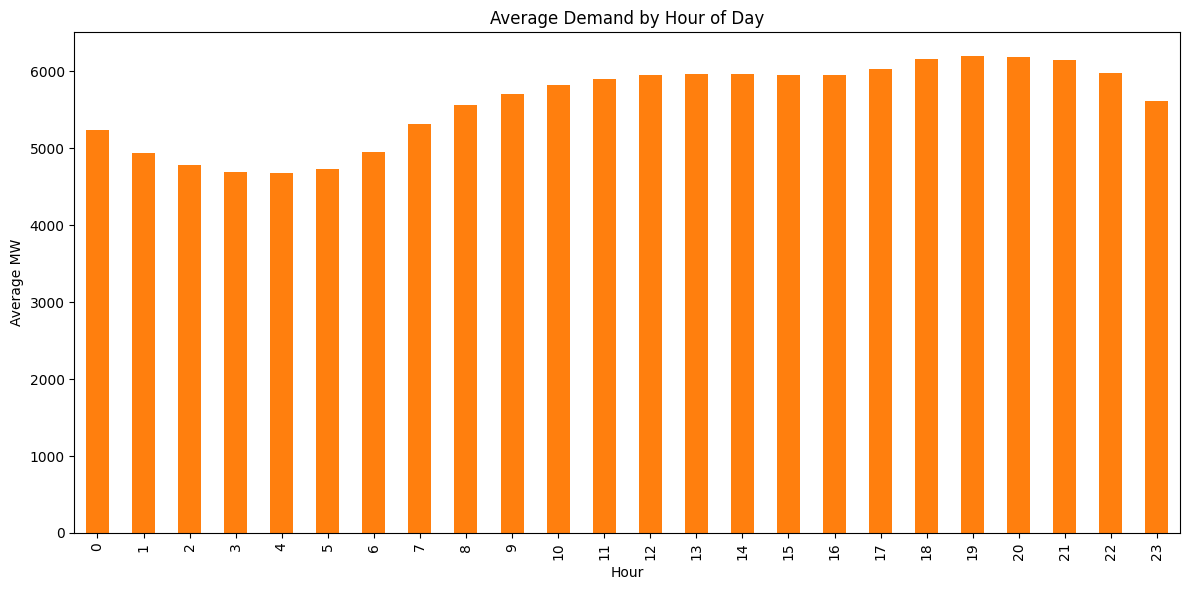

In [ ]:
# Hourly Seasonality
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby(df.index.hour)['MW_clean'].mean()
hourly_avg.plot(kind='bar', color='tab:orange')
plt.title('Average Demand by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average MW')
plt.tight_layout()
plt.show()



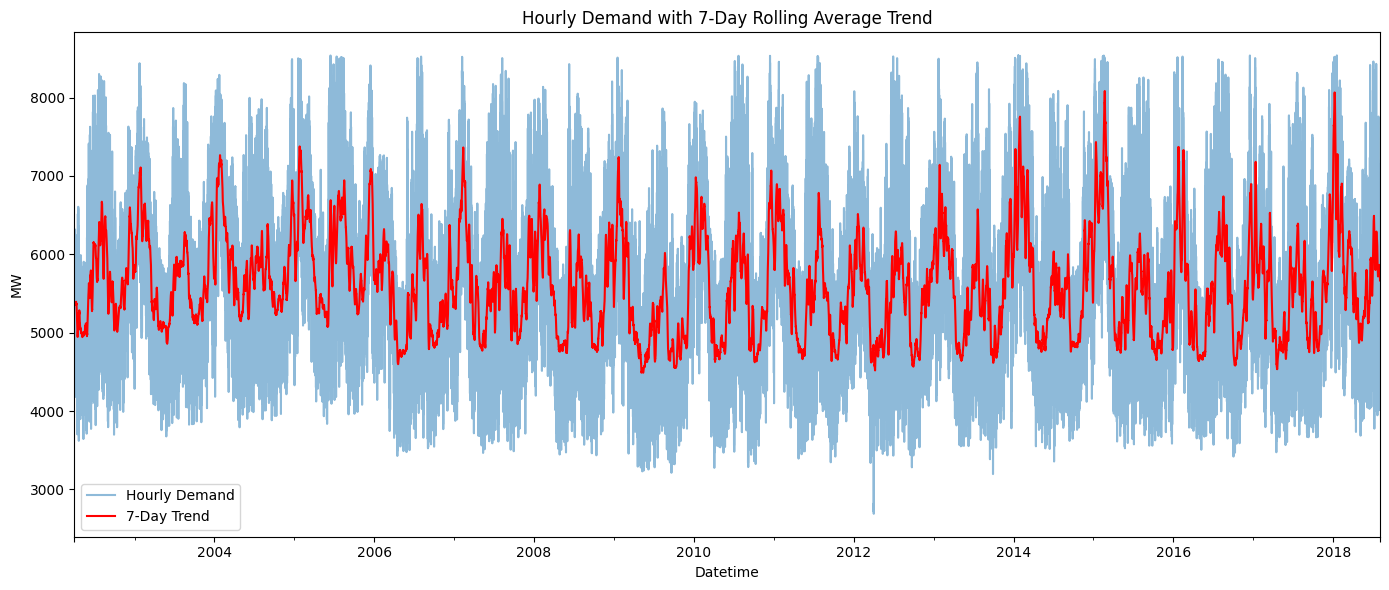

In [ ]:
# Rolling Average Trend
plt.figure(figsize=(14, 6))
df['MW_clean'].plot(label='Hourly Demand', alpha=0.5)
df['MW_clean'].rolling(window=168).mean().plot(label='7-Day Trend', color='red')
plt.title('Hourly Demand with 7-Day Rolling Average Trend')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.tight_layout()
plt.show()




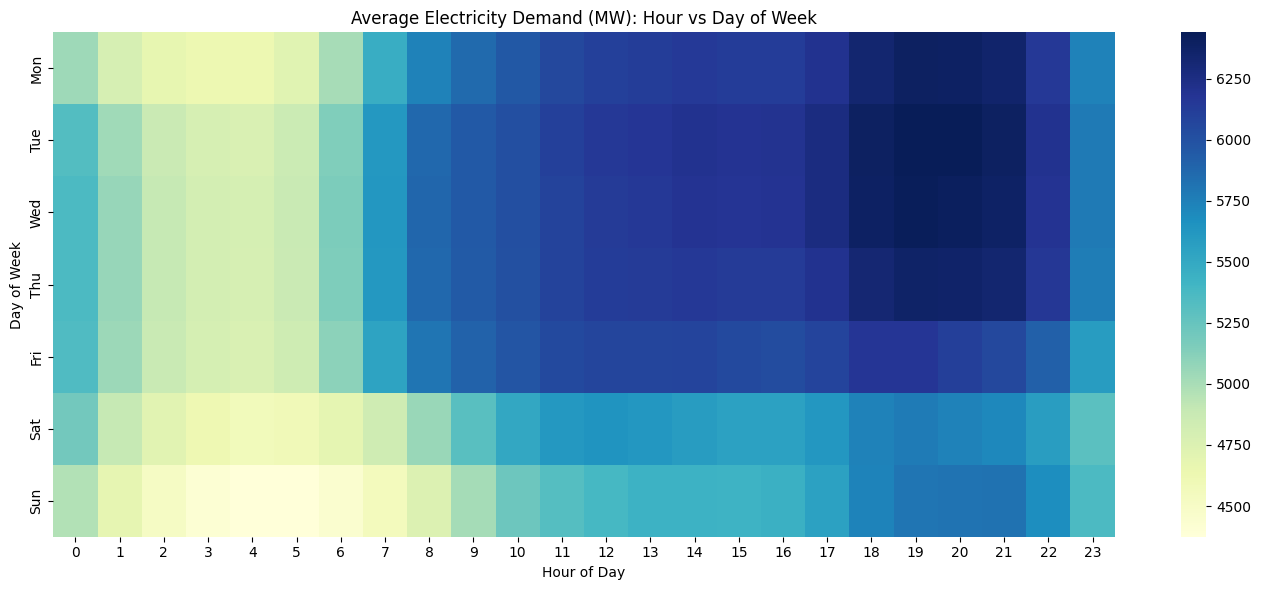

In [ ]:
# Heatmaps
# Hour vs Day of Week
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
pivot = df.pivot_table(values='MW_clean', index='dayofweek', columns='hour', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='YlGnBu', xticklabels=range(24), yticklabels=days)
plt.title('Average Electricity Demand (MW): Hour vs Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [ ]:
import calendar

# Add month number column if not already added
df['month'] = df.index.month
df['hour'] = df.index.hour

# Create the pivot table
monthly_hourly = df.pivot_table(values='MW_clean', index='month', columns='hour', aggfunc='mean')

# Define month order from calendar module (1-based to match DataFrame)
month_order = [calendar.month_abbr[i] for i in range(1, 13)]


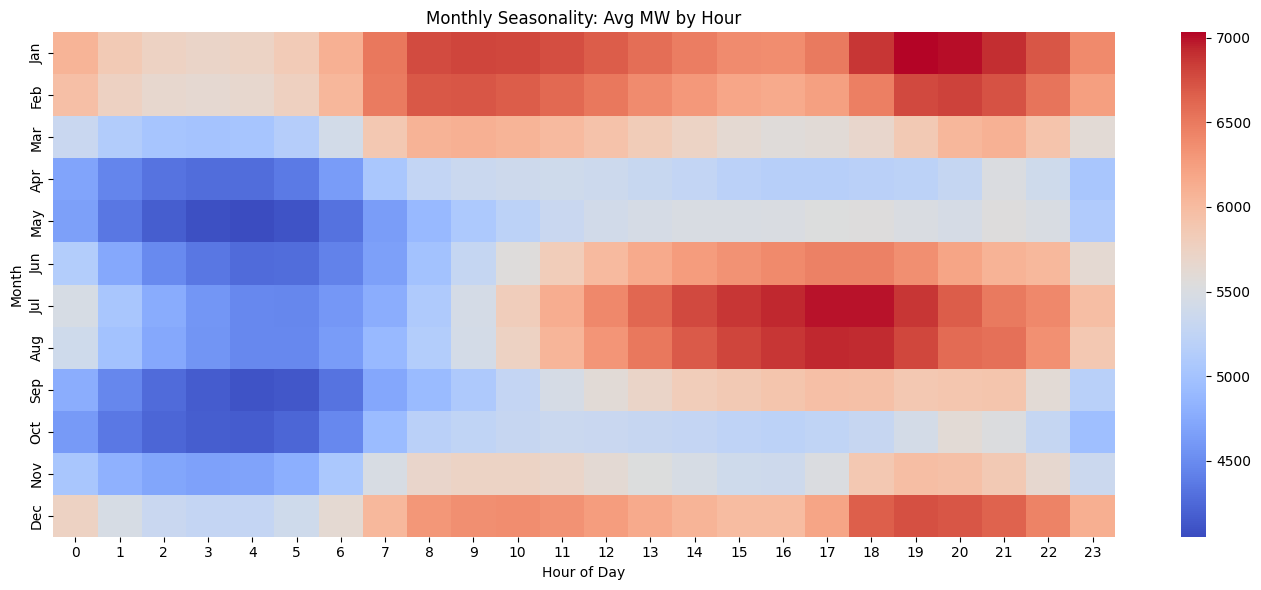

In [ ]:

# Plot
plt.figure(figsize=(14, 6))
sns.heatmap(monthly_hourly, cmap='coolwarm', xticklabels=range(24), yticklabels=month_order)
plt.title('Monthly Seasonality: Avg MW by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


<ipython-input-21-25c575f0f108>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_hourly_clean['cluster'] = kmeans.fit_predict(daily_hourly_clean)


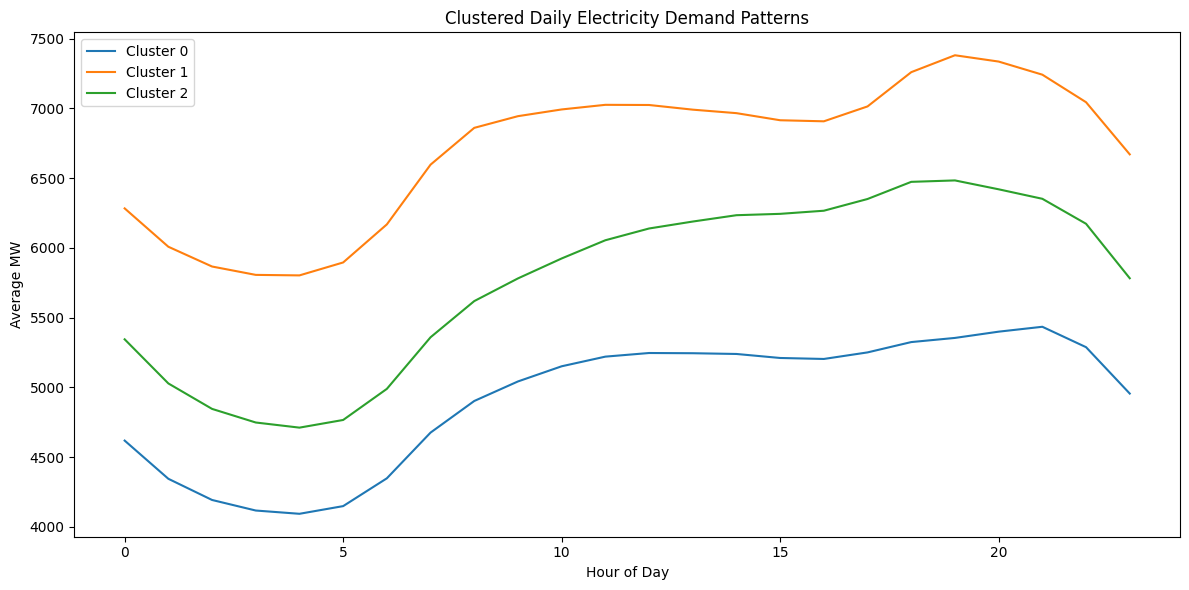

In [ ]:
# Clustering Daily Patterns
daily_hourly = df['MW_clean'].groupby([df.index.date, df.index.hour]).mean().unstack()
daily_hourly_clean = daily_hourly.dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
daily_hourly_clean['cluster'] = kmeans.fit_predict(daily_hourly_clean)

plt.figure(figsize=(12, 6))
for c in range(3):
    avg_pattern = daily_hourly_clean[daily_hourly_clean['cluster'] == c].drop('cluster', axis=1).mean()
    plt.plot(avg_pattern, label=f'Cluster {c}')
plt.title('Clustered Daily Electricity Demand Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Average MW')
plt.legend()
plt.tight_layout()
plt.show()


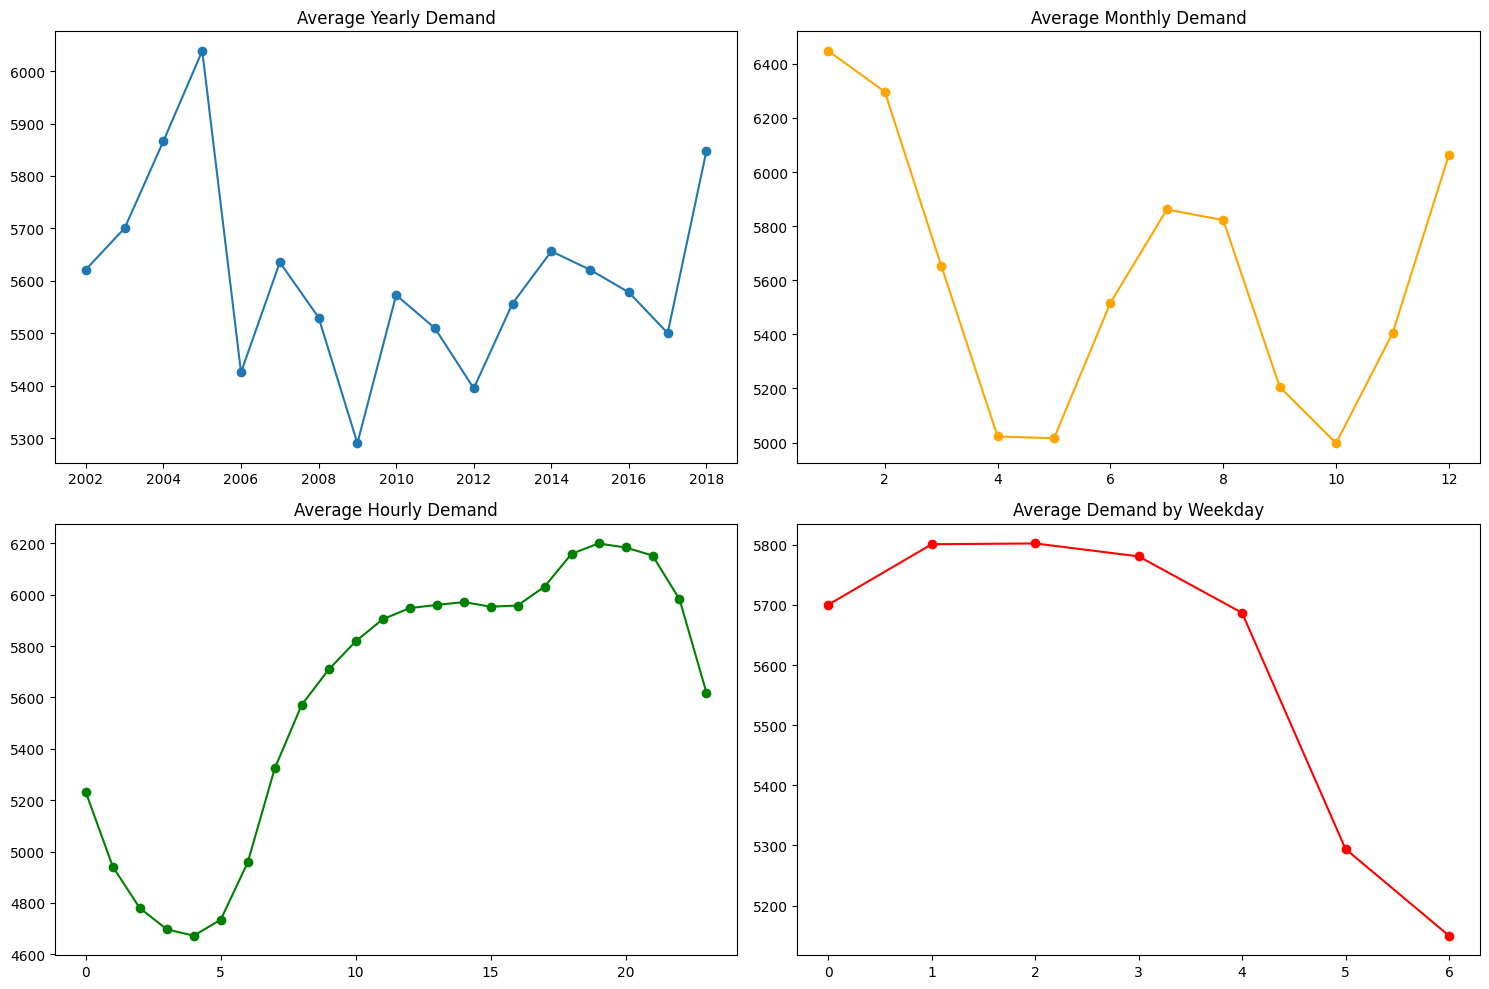

In [ ]:

# Time component extraction for trends
df['day'] = df.index.day
df['year'] = df.index.year
df['weekday'] = df.index.weekday

yearly_avg = df.groupby('year')['PJMW_MW'].mean()
monthly_avg = df.groupby('month')['PJMW_MW'].mean()
hourly_avg = df.groupby('hour')['PJMW_MW'].mean()
weekday_avg = df.groupby('weekday')['PJMW_MW'].mean()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(yearly_avg.index, yearly_avg.values, marker='o')
axs[0, 0].set_title('Average Yearly Demand')
axs[0, 1].plot(monthly_avg.index, monthly_avg.values, marker='o', color='orange')
axs[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', color='green')
axs[1, 1].plot(weekday_avg.index, weekday_avg.values, marker='o', color='red')
axs[0, 1].set_title('Average Monthly Demand')
axs[1, 0].set_title('Average Hourly Demand')
axs[1, 1].set_title('Average Demand by Weekday')
plt.tight_layout()
plt.show()



In [ ]:
title='Average Yearly Demand (MW)'


In [ ]:
import plotly.express as px

# Aggregation
yearly = df.groupby('year')['PJMW_MW'].mean().reset_index()
monthly = df.groupby('month')['PJMW_MW'].mean().reset_index()
hourly = df.groupby('hour')['PJMW_MW'].mean().reset_index()
weekday = df.groupby('weekday')['PJMW_MW'].mean().reset_index()

# Plotting with actual emoji (📈 📆 🕒 🗓️)
px.line(yearly, x='year', y='PJMW_MW', title='📈 Average Yearly Demand (MW)', markers=True).show()


In [ ]:
px.line(monthly, x='month', y='PJMW_MW', title='📆 Average Monthly Demand (MW)', markers=True).show()


In [ ]:
px.line(hourly, x='hour', y='PJMW_MW', title='🕒 Average Hourly Demand (MW)', markers=True).show()


In [ ]:
px.line(weekday, x='weekday', y='PJMW_MW', title='🗓️ Average Weekday Demand (MW)', markers=True).show()


In [ ]:
title='Interactive Time Series of PJMW Electricity Demand'


In [ ]:
import plotly.graph_objs as go

# Interactive time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['PJMW_MW'], mode='lines', name='PJMW Demand'))

fig.update_layout(
    title='📊 Interactive Time Series of PJMW Electricity Demand',  # or just use plain text
    xaxis_title='Date',
    yaxis_title='Demand (MW)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()


In [ ]:
plt.suptitle("Seasonal Decomposition of Daily Electricity Demand", fontsize=16)


Text(0.5, 0.98, 'Seasonal Decomposition of Daily Electricity Demand')

<Figure size 640x480 with 0 Axes>

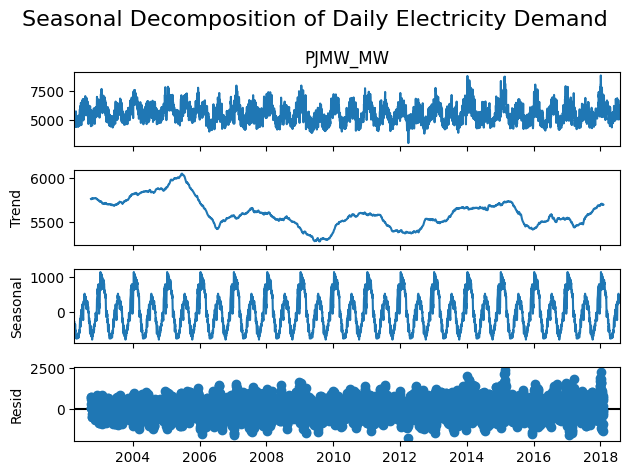

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Seasonal decomposition (daily)
daily_df = df['PJMW_MW'].resample('D').mean()
decomp = seasonal_decompose(daily_df.dropna(), model='additive', period=365)
decomp.plot()

# Replace problematic emoji title
plt.suptitle("Seasonal Decomposition of Daily Electricity Demand", fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
title='Interactive Seasonal Decomposition'


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_df.index, y=decomp.trend, name='Trend'))
fig.add_trace(go.Scatter(x=daily_df.index, y=decomp.seasonal, name='Seasonality'))
fig.add_trace(go.Scatter(x=daily_df.index, y=decomp.resid, name='Residual'))

fig.update_layout(
    title='Interactive Seasonal Decomposition',
    xaxis_title='Date',
    yaxis_title='Value',
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified'
)

fig.show()


In [ ]:
title='Year-over-Year Monthly Demand Comparison'


In [ ]:
df['month_name'] = df.index.strftime('%b')
monthly_by_year = df.groupby(['year', 'month_name'])['PJMW_MW'].mean().reset_index()

# Ensure months are in calendar order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_by_year['month_name'] = pd.Categorical(monthly_by_year['month_name'], categories=month_order, ordered=True)
monthly_by_year.sort_values(['month_name', 'year'], inplace=True)

# Plotly line chart
fig = px.line(
    monthly_by_year,
    x='month_name',
    y='PJMW_MW',
    color='year',
    title='Year-over-Year Monthly Demand Comparison',
    labels={'PJMW_MW': 'Average Demand (MW)', 'month_name': 'Month'}
)
fig.show()
